In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [2]:
import torch

In [3]:
ls -lh /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/*.TABLE

-rw-rw-r-- 1 was966 zitnik 116K Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/GENE.TABLE
-rw-rw-r-- 1 was966 zitnik  55K Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/PATIENT.ITRP.TABLE
-rw-rw-r-- 1 was966 zitnik 1.1M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/PATIENT.TCGA.TABLE
-rw-rw-r-- 1 was966 zitnik  13K Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/pRED.TABLE
-rw-rw-r-- 1 was966 zitnik 2.3M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/TPM.ITRP.TABLE
-rw-rw-r-- 1 was966 zitnik 4.8M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/TPM.TCGA.NORMAL.TABLE
-rw-rw-r-- 1 was966 zitnik  69M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/TPM.TCGA.TABLE


In [4]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/'
df_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))

tcga_label = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
mutation = tcga_label[['tmb', 'cnv', 'msi']] #.fillna(0)

df_tmb = tcga_label[['tmb']]
df_msi = tcga_label[['msi']]
df_msi.msi = df_msi.msi.map({'MSS':1, 'MSI-H':2, 'MSI-L':0})
df_cnv= tcga_label[['cnv']]

df_cancer = tcga_label[['cancer_type']]

df_tpm_normal = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.NORMAL.TABLE'))

/tmp/ipykernel_27345/1340447325.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msi.msi = df_msi.msi.map({'MSS':1, 'MSI-H':2, 'MSI-L':0})


In [5]:
df_msi.msi.unique()

array([ 1.,  2.,  0., nan])

In [6]:
import torch.utils.data as data
from data import TCGAData, GeneData

from aug import MixupNomralAugmentor
from data import TCGAData, GeneData
from model import TCGAPretrainModel
from loss import TripletLoss, TripletCosineLoss, CEWithNaNLabelsLoss, MSEWithNaNLabelsLoss
from saver import SaveBestModel

In [7]:
augmentor = MixupNomralAugmentor(df_tpm_normal, df_tpm_normal.columns, beta=0.7)
train_tcga = TCGAData(df_tpm, df_cancer, df_tmb, df_msi, df_cnv, augmentor)

train_loader = data.DataLoader(train_tcga, batch_size=64, shuffle=True,
                                drop_last=True, pin_memory=True, num_workers=4)

In [8]:
len(train_loader)

159

In [9]:
input_dim = len(train_tcga.feature_name)

In [10]:
device='cuda'
out_emb_dim = 32
model = TCGAPretrainModel(input_dim, middle_emb_dim=512, out_emb_dim=out_emb_dim)
model = torch.jit.script(model).to(device)

In [11]:
lr = 1e-4
weight_decay = 1e-4
from tqdm import tqdm
epochs = 500

optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-4, last_epoch=-1)
saver = SaveBestModel(save_dir = './pretrainTCGA', save_name = 'tcga_best_model.pth')

triplet_loss = torch.jit.script(TripletCosineLoss(margin=1))
ce_loss = torch.jit.script(CEWithNaNLabelsLoss())
mse_loss = torch.jit.script(MSEWithNaNLabelsLoss())

In [12]:
SL_tasks=['tmb'] # 

In [13]:
model.train()
performace = []
for epoch in tqdm(range(epochs), desc="Epochs"):
    total_loss = []
    ssl_loss = []
    tmb_loss = []
    msi_loss = []
    cnv_loss = []
    
    for step, (triplet, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):

        anchor, positive, negative = triplet
        y_tmb, y_msi, y_cnv = anchor_label
        
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        y_tmb = y_tmb.to(device)
        y_msi = y_msi.to(device)
        y_cnv = y_cnv.to(device)
        
        optimizer.zero_grad()
        anchor_emb, anchor_ys = model(anchor)
        positive_emb, _ = model(positive)
        negative_emb, _ = model(negative)
        
        y_tmb_pred, y_msi_pred, y_cnv_pred = anchor_ys   

        ## self-supervised learning loss SSL
        l_ssl = triplet_loss(anchor_emb, positive_emb, negative_emb)
        ssl_loss.append(l_ssl.cpu().detach().numpy())


        loss = l_ssl
        ## supervised learning loss SL
        if 'tmb' in SL_tasks:
            l_tmb = mse_loss(y_tmb_pred, y_tmb)
            tmb_loss.append(l_tmb.cpu().detach().numpy())
            loss += l_tmb

        if 'msi' in SL_tasks:
            l_msi = ce_loss(y_msi_pred, y_msi) / 50
            msi_loss.append(l_msi.cpu().detach().numpy())
            loss += l_msi
            
        if 'cnv' in SL_tasks:
            l_cnv = mse_loss(y_cnv_pred, y_cnv)
            cnv_loss.append(l_cnv.cpu().detach().numpy())
            loss += l_cnv

        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        total_loss.append(loss.cpu().detach().numpy())
    
    train_total_loss =  np.mean(total_loss)
    train_ssl_loss =  np.mean(ssl_loss)
    train_tmb_loss =  np.mean(tmb_loss)
    train_msi_loss =  np.mean(msi_loss)
    train_cnv_loss =  np.mean(cnv_loss)
    
    performace.append([epoch, train_total_loss, train_ssl_loss, 
                       train_tmb_loss, train_msi_loss, train_cnv_loss])

    saver(train_total_loss, epoch, model, optimizer)
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, train_total_loss))
    
saver.save()

Training:  94%|█████████▍| 150/159 [00:04<00:00, 83.29it/s]
                                                           /home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epochs:   0%|          | 1/500 [00:04<38:42,  4.66s/it]

Epoch: 1/500 - Loss: 0.8117



Epochs:   0%|          | 2/500 [00:06<26:26,  3.19s/it]    

Epoch: 2/500 - Loss: 0.6598



Epochs:   1%|          | 3/500 [00:08<22:19,  2.69s/it]    

Epoch: 3/500 - Loss: 0.6131



Epochs:   1%|          | 4/500 [00:10<20:06,  2.43s/it]    

Epoch: 4/500 - Loss: 0.5881



Epochs:   1%|          | 5/500 [00:13<19:09,  2.32s/it]    

Epoch: 5/500 - Loss: 0.5708



Epochs:   1%|          | 6/500 [00:15<18:12,  2.21s/it]    

Epoch: 6/500 - Loss: 0.5570



Epochs:   1%|▏         | 7/500 [00:17<17:45,  2.16s/it]    

Epoch: 7/500 - Loss: 0.5448



Epochs:   2%|▏         | 8/500 [00:19<18:03,  2.20s/it]    

Epoch: 8/500 - Loss: 0.5426



Epochs:   2%|▏         | 9/500 [00:21<18:17,  2.23s/it]    

Epoch: 9/500 - Loss: 0.5251



Epochs:   2%|▏         | 10/500 [00:23<18:02,  2.21s/it]   

Epoch: 10/500 - Loss: 0.5207



Epochs:   2%|▏         | 11/500 [00:25<17:45,  2.18s/it]   

Epoch: 11/500 - Loss: 0.5140



Epochs:   2%|▏         | 12/500 [00:28<17:22,  2.14s/it]   

Epoch: 12/500 - Loss: 0.5054



Epochs:   3%|▎         | 13/500 [00:30<17:06,  2.11s/it]   

Epoch: 13/500 - Loss: 0.4888



Epochs:   3%|▎         | 14/500 [00:32<17:01,  2.10s/it]   

Epoch: 14/500 - Loss: 0.4933



Epochs:   3%|▎         | 15/500 [00:33<16:04,  1.99s/it]    

Epoch: 15/500 - Loss: 0.4959



Epochs:   3%|▎         | 16/500 [00:35<15:38,  1.94s/it]    

Epoch: 16/500 - Loss: 0.4854



Epochs:   3%|▎         | 17/500 [00:37<15:17,  1.90s/it]    

Epoch: 17/500 - Loss: 0.4780



Epochs:   4%|▎         | 18/500 [00:39<15:03,  1.87s/it]    

Epoch: 18/500 - Loss: 0.4744



Epochs:   4%|▍         | 19/500 [00:41<14:48,  1.85s/it]    

Epoch: 19/500 - Loss: 0.4699



Epochs:   4%|▍         | 20/500 [00:42<14:42,  1.84s/it]    

Epoch: 20/500 - Loss: 0.4642



Epochs:   4%|▍         | 21/500 [00:44<14:45,  1.85s/it]   

Epoch: 21/500 - Loss: 0.4558



Epochs:   4%|▍         | 22/500 [00:46<14:27,  1.81s/it]    

Epoch: 22/500 - Loss: 0.4460



Epochs:   5%|▍         | 23/500 [00:48<14:22,  1.81s/it]    

Epoch: 23/500 - Loss: 0.4544



Epochs:   5%|▍         | 24/500 [00:50<14:13,  1.79s/it]    

Epoch: 24/500 - Loss: 0.4494



Epochs:   5%|▌         | 25/500 [00:51<14:06,  1.78s/it]    

Epoch: 25/500 - Loss: 0.4456



Epochs:   5%|▌         | 26/500 [00:53<14:06,  1.79s/it]    

Epoch: 26/500 - Loss: 0.4326



Epochs:   5%|▌         | 27/500 [00:55<14:11,  1.80s/it]    

Epoch: 27/500 - Loss: 0.4287



Epochs:   6%|▌         | 28/500 [00:57<14:04,  1.79s/it]    

Epoch: 28/500 - Loss: 0.4291



Epochs:   6%|▌         | 29/500 [00:59<14:06,  1.80s/it]    

Epoch: 29/500 - Loss: 0.4192



Epochs:   6%|▌         | 30/500 [01:00<14:10,  1.81s/it]    

Epoch: 30/500 - Loss: 0.4201



Epochs:   6%|▌         | 31/500 [01:02<14:20,  1.83s/it]   

Epoch: 31/500 - Loss: 0.4192



Epochs:   6%|▋         | 32/500 [01:04<14:15,  1.83s/it]    

Epoch: 32/500 - Loss: 0.4239



Epochs:   7%|▋         | 33/500 [01:06<14:27,  1.86s/it]   

Epoch: 33/500 - Loss: 0.4225



Epochs:   7%|▋         | 34/500 [01:08<14:23,  1.85s/it]    

Epoch: 34/500 - Loss: 0.4132



Epochs:   7%|▋         | 35/500 [01:10<14:16,  1.84s/it]    

Epoch: 35/500 - Loss: 0.4043



Epochs:   7%|▋         | 36/500 [01:11<14:02,  1.82s/it]    

Epoch: 36/500 - Loss: 0.4123



Epochs:   7%|▋         | 37/500 [01:13<13:48,  1.79s/it]    

Epoch: 37/500 - Loss: 0.4080



Epochs:   8%|▊         | 38/500 [01:15<13:38,  1.77s/it]    

Epoch: 38/500 - Loss: 0.4001



Epochs:   8%|▊         | 39/500 [01:17<13:38,  1.78s/it]    

Epoch: 39/500 - Loss: 0.4034



Epochs:   8%|▊         | 40/500 [01:18<13:35,  1.77s/it]    

Epoch: 40/500 - Loss: 0.3988



Epochs:   8%|▊         | 41/500 [01:20<13:26,  1.76s/it]    

Epoch: 41/500 - Loss: 0.4014



Epochs:   8%|▊         | 42/500 [01:22<13:26,  1.76s/it]    

Epoch: 42/500 - Loss: 0.4001



Epochs:   9%|▊         | 43/500 [01:24<13:27,  1.77s/it]    

Epoch: 43/500 - Loss: 0.3962



Epochs:   9%|▉         | 44/500 [01:25<13:15,  1.74s/it]    

Epoch: 44/500 - Loss: 0.3942



Epochs:   9%|▉         | 45/500 [01:27<13:19,  1.76s/it]    

Epoch: 45/500 - Loss: 0.3940



Epochs:   9%|▉         | 46/500 [01:29<13:19,  1.76s/it]    

Epoch: 46/500 - Loss: 0.3826



Epochs:   9%|▉         | 47/500 [01:31<13:24,  1.78s/it]    

Epoch: 47/500 - Loss: 0.3934



Epochs:  10%|▉         | 48/500 [01:33<13:27,  1.79s/it]    

Epoch: 48/500 - Loss: 0.3883



Epochs:  10%|▉         | 49/500 [01:34<13:15,  1.76s/it]    

Epoch: 49/500 - Loss: 0.3891



Epochs:  10%|█         | 50/500 [01:36<13:34,  1.81s/it]    

Epoch: 50/500 - Loss: 0.3888



Epochs:  10%|█         | 51/500 [01:38<13:25,  1.80s/it]    

Epoch: 51/500 - Loss: 0.3814



Epochs:  10%|█         | 52/500 [01:40<13:18,  1.78s/it]    

Epoch: 52/500 - Loss: 0.3940



Epochs:  11%|█         | 53/500 [01:42<13:21,  1.79s/it]    

Epoch: 53/500 - Loss: 0.3762



Epochs:  11%|█         | 54/500 [01:43<13:17,  1.79s/it]    

Epoch: 54/500 - Loss: 0.3780



Epochs:  11%|█         | 55/500 [01:45<13:23,  1.81s/it]    

Epoch: 55/500 - Loss: 0.3858



Epochs:  11%|█         | 56/500 [01:47<13:16,  1.79s/it]    

Epoch: 56/500 - Loss: 0.3816



Epochs:  11%|█▏        | 57/500 [01:49<13:08,  1.78s/it]    

Epoch: 57/500 - Loss: 0.3794



Epochs:  12%|█▏        | 58/500 [01:50<13:03,  1.77s/it]    

Epoch: 58/500 - Loss: 0.3750



Epochs:  12%|█▏        | 59/500 [01:52<12:56,  1.76s/it]    

Epoch: 59/500 - Loss: 0.3780



Epochs:  12%|█▏        | 60/500 [01:54<13:11,  1.80s/it]    

Epoch: 60/500 - Loss: 0.3737



Epochs:  12%|█▏        | 61/500 [01:56<13:04,  1.79s/it]    

Epoch: 61/500 - Loss: 0.3695



Epochs:  12%|█▏        | 62/500 [01:58<13:03,  1.79s/it]    

Epoch: 62/500 - Loss: 0.3704



Epochs:  13%|█▎        | 63/500 [01:59<12:57,  1.78s/it]    

Epoch: 63/500 - Loss: 0.3745



Epochs:  13%|█▎        | 64/500 [02:01<13:01,  1.79s/it]    

Epoch: 64/500 - Loss: 0.3734



Epochs:  13%|█▎        | 65/500 [02:03<12:47,  1.76s/it]    

Epoch: 65/500 - Loss: 0.3671



Epochs:  13%|█▎        | 66/500 [02:05<12:56,  1.79s/it]    

Epoch: 66/500 - Loss: 0.3640



Epochs:  13%|█▎        | 67/500 [02:07<12:54,  1.79s/it]   

Epoch: 67/500 - Loss: 0.3655



Epochs:  14%|█▎        | 68/500 [02:08<12:49,  1.78s/it]    

Epoch: 68/500 - Loss: 0.3584



Epochs:  14%|█▍        | 69/500 [02:10<12:45,  1.78s/it]    

Epoch: 69/500 - Loss: 0.3605



Epochs:  14%|█▍        | 70/500 [02:12<12:40,  1.77s/it]    

Epoch: 70/500 - Loss: 0.3656



Epochs:  14%|█▍        | 71/500 [02:14<12:36,  1.76s/it]    

Epoch: 71/500 - Loss: 0.3575



Epochs:  14%|█▍        | 72/500 [02:15<12:42,  1.78s/it]    

Epoch: 72/500 - Loss: 0.3642



Epochs:  15%|█▍        | 73/500 [02:17<12:44,  1.79s/it]    

Epoch: 73/500 - Loss: 0.3522



Epochs:  15%|█▍        | 74/500 [02:19<12:35,  1.77s/it]    

Epoch: 74/500 - Loss: 0.3586



Epochs:  15%|█▌        | 75/500 [02:21<12:21,  1.74s/it]    

Epoch: 75/500 - Loss: 0.3620



Epochs:  15%|█▌        | 76/500 [02:22<12:17,  1.74s/it]    

Epoch: 76/500 - Loss: 0.3508



Epochs:  15%|█▌        | 77/500 [02:24<12:19,  1.75s/it]    

Epoch: 77/500 - Loss: 0.3656



Epochs:  16%|█▌        | 78/500 [02:26<12:19,  1.75s/it]    

Epoch: 78/500 - Loss: 0.3618



Epochs:  16%|█▌        | 79/500 [02:28<12:26,  1.77s/it]   

Epoch: 79/500 - Loss: 0.3558



Epochs:  16%|█▌        | 80/500 [02:30<12:36,  1.80s/it]   

Epoch: 80/500 - Loss: 0.3559



Epochs:  16%|█▌        | 81/500 [02:31<12:23,  1.77s/it]    

Epoch: 81/500 - Loss: 0.3608



Epochs:  16%|█▋        | 82/500 [02:33<12:39,  1.82s/it]   

Epoch: 82/500 - Loss: 0.3463



Epochs:  17%|█▋        | 83/500 [02:35<12:39,  1.82s/it]    

Epoch: 83/500 - Loss: 0.3533



Epochs:  17%|█▋        | 84/500 [02:37<12:39,  1.83s/it]    

Epoch: 84/500 - Loss: 0.3495



Epochs:  17%|█▋        | 85/500 [02:39<12:30,  1.81s/it]    

Epoch: 85/500 - Loss: 0.3543



Epochs:  17%|█▋        | 86/500 [02:40<12:23,  1.80s/it]    

Epoch: 86/500 - Loss: 0.3530



Epochs:  17%|█▋        | 87/500 [02:42<12:16,  1.78s/it]    

Epoch: 87/500 - Loss: 0.3551



Epochs:  18%|█▊        | 88/500 [02:44<12:22,  1.80s/it]    

Epoch: 88/500 - Loss: 0.3459



Epochs:  18%|█▊        | 89/500 [02:46<12:19,  1.80s/it]    

Epoch: 89/500 - Loss: 0.3545



Epochs:  18%|█▊        | 90/500 [02:48<12:10,  1.78s/it]    

Epoch: 90/500 - Loss: 0.3489



Epochs:  18%|█▊        | 91/500 [02:49<12:17,  1.80s/it]    

Epoch: 91/500 - Loss: 0.3420



Epochs:  18%|█▊        | 92/500 [02:51<12:21,  1.82s/it]    

Epoch: 92/500 - Loss: 0.3510



Epochs:  19%|█▊        | 93/500 [02:53<12:18,  1.81s/it]    

Epoch: 93/500 - Loss: 0.3513



Epochs:  19%|█▉        | 94/500 [02:55<12:19,  1.82s/it]    

Epoch: 94/500 - Loss: 0.3503



Epochs:  19%|█▉        | 95/500 [02:57<12:23,  1.84s/it]    

Epoch: 95/500 - Loss: 0.3485



Epochs:  19%|█▉        | 96/500 [02:59<12:21,  1.83s/it]    

Epoch: 96/500 - Loss: 0.3471



Epochs:  19%|█▉        | 97/500 [03:00<12:14,  1.82s/it]    

Epoch: 97/500 - Loss: 0.3474



Epochs:  20%|█▉        | 98/500 [03:02<12:06,  1.81s/it]    

Epoch: 98/500 - Loss: 0.3443



Epochs:  20%|█▉        | 99/500 [03:04<12:05,  1.81s/it]    

Epoch: 99/500 - Loss: 0.3456



Epochs:  20%|██        | 100/500 [03:06<12:10,  1.83s/it]   

Epoch: 100/500 - Loss: 0.3345



Epochs:  20%|██        | 101/500 [03:08<12:04,  1.82s/it]   

Epoch: 101/500 - Loss: 0.3415



Epochs:  20%|██        | 102/500 [03:09<12:02,  1.82s/it]   

Epoch: 102/500 - Loss: 0.3370



Epochs:  21%|██        | 103/500 [03:11<12:04,  1.82s/it]  

Epoch: 103/500 - Loss: 0.3354



Epochs:  21%|██        | 104/500 [03:13<11:54,  1.80s/it]   

Epoch: 104/500 - Loss: 0.3459



Epochs:  21%|██        | 105/500 [03:15<11:54,  1.81s/it]   

Epoch: 105/500 - Loss: 0.3416



Epochs:  21%|██        | 106/500 [03:17<11:52,  1.81s/it]   

Epoch: 106/500 - Loss: 0.3379



Epochs:  21%|██▏       | 107/500 [03:18<11:46,  1.80s/it]   

Epoch: 107/500 - Loss: 0.3369



Epochs:  22%|██▏       | 108/500 [03:20<11:42,  1.79s/it]   

Epoch: 108/500 - Loss: 0.3392



Epochs:  22%|██▏       | 109/500 [03:22<11:36,  1.78s/it]   

Epoch: 109/500 - Loss: 0.3378



Epochs:  22%|██▏       | 110/500 [03:24<11:30,  1.77s/it]   

Epoch: 110/500 - Loss: 0.3386



Epochs:  22%|██▏       | 111/500 [03:25<11:20,  1.75s/it]   

Epoch: 111/500 - Loss: 0.3396



Epochs:  22%|██▏       | 112/500 [03:27<11:27,  1.77s/it]   

Epoch: 112/500 - Loss: 0.3374



Epochs:  23%|██▎       | 113/500 [03:29<11:31,  1.79s/it]   

Epoch: 113/500 - Loss: 0.3463



Epochs:  23%|██▎       | 114/500 [03:31<11:30,  1.79s/it]   

Epoch: 114/500 - Loss: 0.3360



Epochs:  23%|██▎       | 115/500 [03:33<11:32,  1.80s/it]   

Epoch: 115/500 - Loss: 0.3307



Epochs:  23%|██▎       | 116/500 [03:34<11:31,  1.80s/it]   

Epoch: 116/500 - Loss: 0.3339



Epochs:  23%|██▎       | 117/500 [03:36<11:37,  1.82s/it]   

Epoch: 117/500 - Loss: 0.3308



Epochs:  26%|██▌       | 128/500 [03:56<11:07,  1.79s/it]   

Epoch: 128/500 - Loss: 0.3307



Epochs:  26%|██▌       | 129/500 [03:58<11:11,  1.81s/it]   

Epoch: 129/500 - Loss: 0.3383



Epochs:  26%|██▌       | 130/500 [04:00<11:13,  1.82s/it]   

Epoch: 130/500 - Loss: 0.3237



Epochs:  26%|██▌       | 131/500 [04:02<10:59,  1.79s/it]   

Epoch: 131/500 - Loss: 0.3254



Epochs:  26%|██▋       | 132/500 [04:03<10:55,  1.78s/it]   

Epoch: 132/500 - Loss: 0.3270



Epochs:  27%|██▋       | 133/500 [04:05<10:50,  1.77s/it]   

Epoch: 133/500 - Loss: 0.3232



Epochs:  27%|██▋       | 134/500 [04:07<11:00,  1.81s/it]   

Epoch: 134/500 - Loss: 0.3259



Epochs:  27%|██▋       | 135/500 [04:09<10:57,  1.80s/it]  

Epoch: 135/500 - Loss: 0.3250



Epochs:  27%|██▋       | 136/500 [04:11<11:06,  1.83s/it]   

Epoch: 136/500 - Loss: 0.3281



Epochs:  27%|██▋       | 137/500 [04:12<10:50,  1.79s/it]   

Epoch: 137/500 - Loss: 0.3279



Epochs:  28%|██▊       | 138/500 [04:14<10:47,  1.79s/it]   

Epoch: 138/500 - Loss: 0.3328



Epochs:  28%|██▊       | 139/500 [04:16<10:40,  1.77s/it]   

Epoch: 139/500 - Loss: 0.3267



Epochs:  28%|██▊       | 140/500 [04:18<10:41,  1.78s/it]   

Epoch: 140/500 - Loss: 0.3259



Epochs:  28%|██▊       | 141/500 [04:19<10:39,  1.78s/it]   

Epoch: 141/500 - Loss: 0.3200



Epochs:  28%|██▊       | 142/500 [04:21<10:46,  1.81s/it]   

Epoch: 142/500 - Loss: 0.3216



Epochs:  29%|██▊       | 143/500 [04:23<10:38,  1.79s/it]   

Epoch: 143/500 - Loss: 0.3263



Epochs:  29%|██▉       | 144/500 [04:25<10:32,  1.78s/it]   

Epoch: 144/500 - Loss: 0.3275



Epochs:  29%|██▉       | 145/500 [04:27<10:29,  1.77s/it]   

Epoch: 145/500 - Loss: 0.3225



Epochs:  29%|██▉       | 146/500 [04:28<10:19,  1.75s/it]   

Epoch: 146/500 - Loss: 0.3280



Epochs:  29%|██▉       | 147/500 [04:30<10:18,  1.75s/it]   

Epoch: 147/500 - Loss: 0.3289



Epochs:  30%|██▉       | 148/500 [04:32<10:16,  1.75s/it]   

Epoch: 148/500 - Loss: 0.3256



Epochs:  30%|██▉       | 149/500 [04:34<10:17,  1.76s/it]   

Epoch: 149/500 - Loss: 0.3226



Epochs:  30%|███       | 150/500 [04:35<10:19,  1.77s/it]   

Epoch: 150/500 - Loss: 0.3194



Epochs:  30%|███       | 151/500 [04:37<10:15,  1.76s/it]   

Epoch: 151/500 - Loss: 0.3289



Epochs:  30%|███       | 152/500 [04:39<10:09,  1.75s/it]   

Epoch: 152/500 - Loss: 0.3208



Epochs:  31%|███       | 153/500 [04:41<10:16,  1.78s/it]   

Epoch: 153/500 - Loss: 0.3166



Epochs:  31%|███       | 154/500 [04:42<10:19,  1.79s/it]   

Epoch: 154/500 - Loss: 0.3145



Epochs:  31%|███       | 155/500 [04:44<10:11,  1.77s/it]   

Epoch: 155/500 - Loss: 0.3178



Epochs:  31%|███       | 156/500 [04:46<10:12,  1.78s/it]   

Epoch: 156/500 - Loss: 0.3167



Epochs:  31%|███▏      | 157/500 [04:48<10:08,  1.77s/it]   

Epoch: 157/500 - Loss: 0.3184



Epochs:  32%|███▏      | 158/500 [04:49<10:04,  1.77s/it]   

Epoch: 158/500 - Loss: 0.3172



Epochs:  32%|███▏      | 159/500 [04:51<10:13,  1.80s/it]   

Epoch: 159/500 - Loss: 0.3210



Epochs:  32%|███▏      | 160/500 [04:53<10:17,  1.82s/it]   

Epoch: 160/500 - Loss: 0.3129



Epochs:  32%|███▏      | 161/500 [04:55<10:09,  1.80s/it]   

Epoch: 161/500 - Loss: 0.3206



Epochs:  32%|███▏      | 162/500 [04:57<10:05,  1.79s/it]  

Epoch: 162/500 - Loss: 0.3199



Epochs:  33%|███▎      | 163/500 [04:59<10:02,  1.79s/it]   

Epoch: 163/500 - Loss: 0.3242



Epochs:  33%|███▎      | 164/500 [05:00<09:57,  1.78s/it]   

Epoch: 164/500 - Loss: 0.3168



Epochs:  33%|███▎      | 165/500 [05:02<09:50,  1.76s/it]   

Epoch: 165/500 - Loss: 0.3219



Epochs:  33%|███▎      | 166/500 [05:04<09:54,  1.78s/it]   

Epoch: 166/500 - Loss: 0.3139



Epochs:  33%|███▎      | 167/500 [05:06<09:46,  1.76s/it]   

Epoch: 167/500 - Loss: 0.3142



Epochs:  34%|███▎      | 168/500 [05:07<09:47,  1.77s/it]   

Epoch: 168/500 - Loss: 0.3193



Epochs:  34%|███▍      | 169/500 [05:09<09:43,  1.76s/it]   

Epoch: 169/500 - Loss: 0.3225



Epochs:  34%|███▍      | 170/500 [05:11<09:50,  1.79s/it]   

Epoch: 170/500 - Loss: 0.3171



Epochs:  34%|███▍      | 171/500 [05:13<09:49,  1.79s/it]   

Epoch: 171/500 - Loss: 0.3185



Epochs:  34%|███▍      | 172/500 [05:14<09:44,  1.78s/it]   

Epoch: 172/500 - Loss: 0.3212



Epochs:  35%|███▍      | 173/500 [05:16<09:43,  1.79s/it]   

Epoch: 173/500 - Loss: 0.3118



Epochs:  35%|███▍      | 174/500 [05:18<09:39,  1.78s/it]   

Epoch: 174/500 - Loss: 0.3071



Epochs:  35%|███▌      | 175/500 [05:20<09:37,  1.78s/it]   

Epoch: 175/500 - Loss: 0.3205



Epochs:  35%|███▌      | 176/500 [05:22<09:38,  1.79s/it]   

Epoch: 176/500 - Loss: 0.3260



Epochs:  35%|███▌      | 177/500 [05:23<09:40,  1.80s/it]   

Epoch: 177/500 - Loss: 0.3107



Epochs:  36%|███▌      | 178/500 [05:25<09:40,  1.80s/it]  

Epoch: 178/500 - Loss: 0.3198



Epochs:  36%|███▌      | 179/500 [05:27<09:48,  1.83s/it]   

Epoch: 179/500 - Loss: 0.3147



Epochs:  36%|███▌      | 180/500 [05:29<09:41,  1.82s/it]   

Epoch: 180/500 - Loss: 0.3134



Epochs:  36%|███▌      | 181/500 [05:31<09:44,  1.83s/it]   

Epoch: 181/500 - Loss: 0.3087



Epochs:  36%|███▋      | 182/500 [05:33<09:40,  1.82s/it]   

Epoch: 182/500 - Loss: 0.3100



Epochs:  37%|███▋      | 183/500 [05:34<09:34,  1.81s/it]   

Epoch: 183/500 - Loss: 0.3122



Epochs:  37%|███▋      | 184/500 [05:36<09:41,  1.84s/it]  

Epoch: 184/500 - Loss: 0.3143



Epochs:  37%|███▋      | 185/500 [05:38<09:48,  1.87s/it]  

Epoch: 185/500 - Loss: 0.3017



Epochs:  37%|███▋      | 186/500 [05:40<09:49,  1.88s/it]   

Epoch: 186/500 - Loss: 0.3053



Epochs:  37%|███▋      | 187/500 [05:42<09:49,  1.88s/it]  

Epoch: 187/500 - Loss: 0.3081



Epochs:  38%|███▊      | 188/500 [05:44<09:37,  1.85s/it]   

Epoch: 188/500 - Loss: 0.3146



Epochs:  38%|███▊      | 189/500 [05:46<09:37,  1.86s/it]   

Epoch: 189/500 - Loss: 0.3103



Epochs:  38%|███▊      | 190/500 [05:48<09:36,  1.86s/it]   

Epoch: 190/500 - Loss: 0.3140



Epochs:  38%|███▊      | 191/500 [05:49<09:32,  1.85s/it]   

Epoch: 191/500 - Loss: 0.3138



Epochs:  38%|███▊      | 192/500 [05:51<09:23,  1.83s/it]   

Epoch: 192/500 - Loss: 0.3145



Epochs:  39%|███▊      | 193/500 [05:54<10:15,  2.00s/it]  

Epoch: 193/500 - Loss: 0.3038



Epochs:  39%|███▉      | 194/500 [05:56<11:30,  2.26s/it]  

Epoch: 194/500 - Loss: 0.3144



Epochs:  39%|███▉      | 195/500 [05:59<11:15,  2.22s/it]  

Epoch: 195/500 - Loss: 0.3058



Epochs:  39%|███▉      | 196/500 [06:01<11:31,  2.27s/it]  

Epoch: 196/500 - Loss: 0.3030



Epochs:  39%|███▉      | 197/500 [06:03<11:34,  2.29s/it]  

Epoch: 197/500 - Loss: 0.3122



Epochs:  40%|███▉      | 198/500 [06:05<11:13,  2.23s/it]   

Epoch: 198/500 - Loss: 0.3156



Epochs:  40%|███▉      | 199/500 [06:08<11:24,  2.27s/it]  

Epoch: 199/500 - Loss: 0.3093



Epochs:  40%|████      | 200/500 [06:10<11:07,  2.23s/it]   

Epoch: 200/500 - Loss: 0.3171



Epochs:  40%|████      | 201/500 [06:12<10:50,  2.18s/it]   

Epoch: 201/500 - Loss: 0.3118



Epochs:  40%|████      | 202/500 [06:14<10:57,  2.21s/it]   

Epoch: 202/500 - Loss: 0.3012



Epochs:  41%|████      | 203/500 [06:16<10:37,  2.15s/it]  

Epoch: 203/500 - Loss: 0.3119



Epochs:  41%|████      | 204/500 [06:18<10:20,  2.10s/it]  

Epoch: 204/500 - Loss: 0.3007



Epochs:  41%|████      | 205/500 [06:21<11:00,  2.24s/it]  

Epoch: 205/500 - Loss: 0.3051



Epochs:  41%|████      | 206/500 [06:23<11:18,  2.31s/it]  

Epoch: 206/500 - Loss: 0.3054



Epochs:  41%|████▏     | 207/500 [06:26<11:23,  2.33s/it]  

Epoch: 207/500 - Loss: 0.3156



Epochs:  42%|████▏     | 208/500 [06:28<11:25,  2.35s/it]  

Epoch: 208/500 - Loss: 0.2988



Epochs:  42%|████▏     | 209/500 [06:31<11:38,  2.40s/it]  

Epoch: 209/500 - Loss: 0.2989



Epochs:  42%|████▏     | 210/500 [06:33<11:45,  2.43s/it]  

Epoch: 210/500 - Loss: 0.3133



Epochs:  42%|████▏     | 211/500 [06:36<12:01,  2.50s/it]  

Epoch: 211/500 - Loss: 0.3110



Epochs:  42%|████▏     | 212/500 [06:38<12:21,  2.57s/it]  

Epoch: 212/500 - Loss: 0.3058



Epochs:  43%|████▎     | 213/500 [06:42<13:11,  2.76s/it]  

Epoch: 213/500 - Loss: 0.3112



Epochs:  43%|████▎     | 214/500 [06:44<12:52,  2.70s/it]  

Epoch: 214/500 - Loss: 0.3037



Epochs:  43%|████▎     | 215/500 [06:46<12:07,  2.55s/it]  

Epoch: 215/500 - Loss: 0.3020



Epochs:  43%|████▎     | 216/500 [06:49<11:58,  2.53s/it]  

Epoch: 216/500 - Loss: 0.3041



Epochs:  43%|████▎     | 217/500 [06:51<11:48,  2.51s/it]  

Epoch: 217/500 - Loss: 0.3045



Epochs:  44%|████▎     | 218/500 [06:54<11:49,  2.52s/it]  

Epoch: 218/500 - Loss: 0.3064



Epochs:  44%|████▍     | 219/500 [06:56<11:51,  2.53s/it]  

Epoch: 219/500 - Loss: 0.3044



Epochs:  44%|████▍     | 220/500 [06:59<11:54,  2.55s/it]  

Epoch: 220/500 - Loss: 0.3085



Epochs:  44%|████▍     | 221/500 [07:02<11:55,  2.56s/it]  

Epoch: 221/500 - Loss: 0.3039



Epochs:  44%|████▍     | 222/500 [07:04<11:49,  2.55s/it]  

Epoch: 222/500 - Loss: 0.3056



Epochs:  45%|████▍     | 223/500 [07:07<12:00,  2.60s/it]  

Epoch: 223/500 - Loss: 0.3014



Epochs:  45%|████▍     | 224/500 [07:09<11:55,  2.59s/it]  

Epoch: 224/500 - Loss: 0.3065



Epochs:  45%|████▌     | 225/500 [07:12<11:51,  2.59s/it]  

Epoch: 225/500 - Loss: 0.3074



Epochs:  45%|████▌     | 226/500 [07:15<11:47,  2.58s/it]  

Epoch: 226/500 - Loss: 0.3113



Epochs:  45%|████▌     | 227/500 [07:17<11:33,  2.54s/it]  

Epoch: 227/500 - Loss: 0.2992



Epochs:  46%|████▌     | 228/500 [07:20<11:50,  2.61s/it]  

Epoch: 228/500 - Loss: 0.2984



Epochs:  46%|████▌     | 229/500 [07:22<11:42,  2.59s/it]  

Epoch: 229/500 - Loss: 0.3020



Epochs:  46%|████▌     | 230/500 [07:25<11:42,  2.60s/it]  

Epoch: 230/500 - Loss: 0.2964



Epochs:  46%|████▌     | 231/500 [07:27<11:33,  2.58s/it]  

Epoch: 231/500 - Loss: 0.3038



Epochs:  46%|████▋     | 232/500 [07:30<11:15,  2.52s/it]  

Epoch: 232/500 - Loss: 0.3052



Epochs:  47%|████▋     | 233/500 [07:33<11:23,  2.56s/it]  

Epoch: 233/500 - Loss: 0.2977



Epochs:  47%|████▋     | 234/500 [07:35<11:23,  2.57s/it]  

Epoch: 234/500 - Loss: 0.3046



Epochs:  47%|████▋     | 235/500 [07:38<11:13,  2.54s/it]  

Epoch: 235/500 - Loss: 0.2965



Epochs:  47%|████▋     | 236/500 [07:40<11:07,  2.53s/it]  

Epoch: 236/500 - Loss: 0.3002



Epochs:  47%|████▋     | 237/500 [07:43<11:04,  2.53s/it]  

Epoch: 237/500 - Loss: 0.3039



Epochs:  48%|████▊     | 238/500 [07:45<11:12,  2.57s/it]  

Epoch: 238/500 - Loss: 0.3050



Epochs:  48%|████▊     | 239/500 [07:48<10:58,  2.52s/it]  

Epoch: 239/500 - Loss: 0.3025



Epochs:  48%|████▊     | 240/500 [07:50<11:00,  2.54s/it]  

Epoch: 240/500 - Loss: 0.3031



Epochs:  48%|████▊     | 241/500 [07:53<11:04,  2.57s/it]  

Epoch: 241/500 - Loss: 0.2985



Epochs:  48%|████▊     | 242/500 [07:55<10:48,  2.51s/it]  

Epoch: 242/500 - Loss: 0.2942



Epochs:  49%|████▊     | 243/500 [07:58<10:33,  2.47s/it]  

Epoch: 243/500 - Loss: 0.3035



Epochs:  49%|████▉     | 244/500 [08:00<10:36,  2.48s/it]  

Epoch: 244/500 - Loss: 0.3011



Epochs:  49%|████▉     | 245/500 [08:03<10:40,  2.51s/it]  

Epoch: 245/500 - Loss: 0.2956



Epochs:  49%|████▉     | 246/500 [08:05<10:24,  2.46s/it]  

Epoch: 246/500 - Loss: 0.3002



Epochs:  49%|████▉     | 247/500 [08:07<10:08,  2.40s/it]  

Epoch: 247/500 - Loss: 0.2990



Epochs:  50%|████▉     | 248/500 [08:09<09:42,  2.31s/it]  

Epoch: 248/500 - Loss: 0.3042



Epochs:  50%|████▉     | 249/500 [08:11<09:08,  2.19s/it]  

Epoch: 249/500 - Loss: 0.3016



Epochs:  50%|█████     | 250/500 [08:13<08:49,  2.12s/it]  

Epoch: 250/500 - Loss: 0.2941



Epochs:  50%|█████     | 251/500 [08:15<08:38,  2.08s/it]  

Epoch: 251/500 - Loss: 0.3020



Epochs:  50%|█████     | 252/500 [08:17<08:32,  2.07s/it]  

Epoch: 252/500 - Loss: 0.2982



Epochs:  51%|█████     | 253/500 [08:19<08:30,  2.07s/it]  

Epoch: 253/500 - Loss: 0.2980



Epochs:  51%|█████     | 254/500 [08:21<08:23,  2.05s/it]  

Epoch: 254/500 - Loss: 0.2928



Epochs:  51%|█████     | 255/500 [08:23<08:24,  2.06s/it]  

Epoch: 255/500 - Loss: 0.2975



Epochs:  51%|█████     | 256/500 [08:26<08:27,  2.08s/it]  

Epoch: 256/500 - Loss: 0.2979



Epochs:  51%|█████▏    | 257/500 [08:28<08:25,  2.08s/it]  

Epoch: 257/500 - Loss: 0.2941



Epochs:  52%|█████▏    | 258/500 [08:30<08:25,  2.09s/it]  

Epoch: 258/500 - Loss: 0.2957



Epochs:  52%|█████▏    | 259/500 [08:32<08:19,  2.07s/it]  

Epoch: 259/500 - Loss: 0.2982



Epochs:  52%|█████▏    | 260/500 [08:34<08:23,  2.10s/it]  

Epoch: 260/500 - Loss: 0.2930



Epochs:  52%|█████▏    | 261/500 [08:36<08:14,  2.07s/it]  

Epoch: 261/500 - Loss: 0.2956



Epochs:  52%|█████▏    | 262/500 [08:38<08:10,  2.06s/it]  

Epoch: 262/500 - Loss: 0.2899



Epochs:  53%|█████▎    | 263/500 [08:40<08:08,  2.06s/it]  

Epoch: 263/500 - Loss: 0.2952



Epochs:  53%|█████▎    | 264/500 [08:42<08:01,  2.04s/it]  

Epoch: 264/500 - Loss: 0.2979



Epochs:  53%|█████▎    | 265/500 [08:44<07:55,  2.02s/it]  

Epoch: 265/500 - Loss: 0.2890



Epochs:  53%|█████▎    | 266/500 [08:46<07:53,  2.02s/it]  

Epoch: 266/500 - Loss: 0.3006



Epochs:  53%|█████▎    | 267/500 [08:48<07:59,  2.06s/it]  

Epoch: 267/500 - Loss: 0.2928



Epochs:  54%|█████▎    | 268/500 [08:50<08:02,  2.08s/it]  

Epoch: 268/500 - Loss: 0.3042



Epochs:  54%|█████▍    | 269/500 [08:53<08:12,  2.13s/it]  

Epoch: 269/500 - Loss: 0.2941



Epochs:  54%|█████▍    | 270/500 [08:55<08:05,  2.11s/it]  

Epoch: 270/500 - Loss: 0.2949



Epochs:  54%|█████▍    | 271/500 [08:57<07:57,  2.09s/it]  

Epoch: 271/500 - Loss: 0.2978



Epochs:  54%|█████▍    | 272/500 [08:59<07:45,  2.04s/it]  

Epoch: 272/500 - Loss: 0.2938



Epochs:  55%|█████▍    | 273/500 [09:01<07:45,  2.05s/it]  

Epoch: 273/500 - Loss: 0.2902



Epochs:  55%|█████▍    | 274/500 [09:03<07:55,  2.10s/it]  

Epoch: 274/500 - Loss: 0.2912



Epochs:  55%|█████▌    | 275/500 [09:05<07:38,  2.04s/it]   

Epoch: 275/500 - Loss: 0.2871



Epochs:  55%|█████▌    | 276/500 [09:07<07:19,  1.96s/it]   

Epoch: 276/500 - Loss: 0.2945



Epochs:  55%|█████▌    | 277/500 [09:09<07:12,  1.94s/it]   

Epoch: 277/500 - Loss: 0.2909



Epochs:  56%|█████▌    | 278/500 [09:10<07:00,  1.89s/it]   

Epoch: 278/500 - Loss: 0.2942



Epochs:  56%|█████▌    | 279/500 [09:12<06:47,  1.84s/it]   

Epoch: 279/500 - Loss: 0.2888



Epochs:  56%|█████▌    | 280/500 [09:14<06:44,  1.84s/it]   

Epoch: 280/500 - Loss: 0.2950



Epochs:  56%|█████▌    | 281/500 [09:16<06:37,  1.82s/it]   

Epoch: 281/500 - Loss: 0.2931



Epochs:  56%|█████▋    | 282/500 [09:17<06:34,  1.81s/it]   

Epoch: 282/500 - Loss: 0.2950



Epochs:  57%|█████▋    | 283/500 [09:19<06:32,  1.81s/it]  

Epoch: 283/500 - Loss: 0.2914



Epochs:  57%|█████▋    | 284/500 [09:21<06:28,  1.80s/it]   

Epoch: 284/500 - Loss: 0.2946



Epochs:  57%|█████▋    | 285/500 [09:23<06:30,  1.82s/it]   

Epoch: 285/500 - Loss: 0.2925



Epochs:  57%|█████▋    | 286/500 [09:25<06:33,  1.84s/it]   

Epoch: 286/500 - Loss: 0.2932



Epochs:  57%|█████▋    | 287/500 [09:27<06:28,  1.82s/it]   

Epoch: 287/500 - Loss: 0.2905



Epochs:  58%|█████▊    | 288/500 [09:28<06:29,  1.84s/it]   

Epoch: 288/500 - Loss: 0.2987



Epochs:  58%|█████▊    | 289/500 [09:30<06:34,  1.87s/it]   

Epoch: 289/500 - Loss: 0.2921



Epochs:  58%|█████▊    | 290/500 [09:32<06:33,  1.87s/it]   

Epoch: 290/500 - Loss: 0.2941



Epochs:  58%|█████▊    | 291/500 [09:34<06:30,  1.87s/it]  

Epoch: 291/500 - Loss: 0.2894



Epochs:  58%|█████▊    | 292/500 [09:36<06:25,  1.85s/it]   

Epoch: 292/500 - Loss: 0.2905



Epochs:  59%|█████▊    | 293/500 [09:38<06:19,  1.83s/it]   

Epoch: 293/500 - Loss: 0.2823



Epochs:  59%|█████▉    | 294/500 [09:39<06:15,  1.82s/it]   

Epoch: 294/500 - Loss: 0.2976



Epochs:  59%|█████▉    | 295/500 [09:41<06:11,  1.81s/it]   

Epoch: 295/500 - Loss: 0.2903



Epochs:  59%|█████▉    | 296/500 [09:43<06:06,  1.80s/it]   

Epoch: 296/500 - Loss: 0.2872



Epochs:  59%|█████▉    | 297/500 [09:45<06:05,  1.80s/it]   

Epoch: 297/500 - Loss: 0.2858



Epochs:  60%|█████▉    | 298/500 [09:47<06:06,  1.81s/it]   

Epoch: 298/500 - Loss: 0.2917



Epochs:  60%|█████▉    | 299/500 [09:48<06:02,  1.80s/it]  

Epoch: 299/500 - Loss: 0.2872



Epochs:  60%|██████    | 300/500 [09:50<06:03,  1.82s/it]   

Epoch: 300/500 - Loss: 0.2906



Epochs:  60%|██████    | 301/500 [09:52<06:08,  1.85s/it]   

Epoch: 301/500 - Loss: 0.2890



Epochs:  60%|██████    | 302/500 [09:54<06:05,  1.85s/it]   

Epoch: 302/500 - Loss: 0.2877



Epochs:  61%|██████    | 303/500 [09:56<06:08,  1.87s/it]  

Epoch: 303/500 - Loss: 0.2963



Epochs:  61%|██████    | 304/500 [09:58<06:06,  1.87s/it]   

Epoch: 304/500 - Loss: 0.2925



Epochs:  61%|██████    | 305/500 [10:00<06:07,  1.88s/it]   

Epoch: 305/500 - Loss: 0.2892



Epochs:  61%|██████    | 306/500 [10:02<06:14,  1.93s/it]   

Epoch: 306/500 - Loss: 0.2909



Epochs:  61%|██████▏   | 307/500 [10:04<06:11,  1.93s/it]  

Epoch: 307/500 - Loss: 0.2904



Epochs:  62%|██████▏   | 308/500 [10:06<06:11,  1.93s/it]  

Epoch: 308/500 - Loss: 0.2927



Epochs:  62%|██████▏   | 309/500 [10:08<06:14,  1.96s/it]  

Epoch: 309/500 - Loss: 0.2973



Epochs:  62%|██████▏   | 310/500 [10:10<06:15,  1.98s/it]  

Epoch: 310/500 - Loss: 0.2851



Epochs:  62%|██████▏   | 311/500 [10:12<06:06,  1.94s/it]   

Epoch: 311/500 - Loss: 0.2896



Epochs:  62%|██████▏   | 312/500 [10:14<06:05,  1.94s/it]  

Epoch: 312/500 - Loss: 0.2867



Epochs:  63%|██████▎   | 313/500 [10:16<06:14,  2.00s/it]  

Epoch: 313/500 - Loss: 0.2838



Epochs:  63%|██████▎   | 314/500 [10:18<06:37,  2.14s/it]  

Epoch: 314/500 - Loss: 0.2948



Epochs:  63%|██████▎   | 315/500 [10:21<07:03,  2.29s/it]  

Epoch: 315/500 - Loss: 0.2947



Epochs:  63%|██████▎   | 316/500 [10:23<06:54,  2.25s/it]  

Epoch: 316/500 - Loss: 0.2882



Epochs:  63%|██████▎   | 317/500 [10:26<07:28,  2.45s/it]  

Epoch: 317/500 - Loss: 0.2824



Epochs:  64%|██████▎   | 318/500 [10:29<07:36,  2.51s/it]  

Epoch: 318/500 - Loss: 0.2991



Epochs:  64%|██████▍   | 319/500 [10:31<07:28,  2.48s/it]  

Epoch: 319/500 - Loss: 0.2867



Epochs:  64%|██████▍   | 320/500 [10:33<07:26,  2.48s/it]  

Epoch: 320/500 - Loss: 0.2901



Epochs:  64%|██████▍   | 321/500 [10:36<07:18,  2.45s/it]  

Epoch: 321/500 - Loss: 0.2843



Epochs:  64%|██████▍   | 322/500 [10:38<07:25,  2.50s/it]  

Epoch: 322/500 - Loss: 0.2902



Epochs:  65%|██████▍   | 323/500 [10:41<07:36,  2.58s/it]  

Epoch: 323/500 - Loss: 0.2892



Epochs:  65%|██████▍   | 324/500 [10:44<07:35,  2.59s/it]  

Epoch: 324/500 - Loss: 0.2951



Epochs:  65%|██████▌   | 325/500 [10:46<07:27,  2.56s/it]  

Epoch: 325/500 - Loss: 0.2932



Epochs:  65%|██████▌   | 326/500 [10:49<07:20,  2.53s/it]  

Epoch: 326/500 - Loss: 0.2816



Epochs:  65%|██████▌   | 327/500 [10:51<07:08,  2.48s/it]  

Epoch: 327/500 - Loss: 0.2875



Epochs:  66%|██████▌   | 328/500 [10:54<07:12,  2.51s/it]  

Epoch: 328/500 - Loss: 0.2872



Epochs:  66%|██████▌   | 329/500 [10:56<07:05,  2.49s/it]  

Epoch: 329/500 - Loss: 0.2870



Epochs:  66%|██████▌   | 330/500 [10:59<07:07,  2.52s/it]  

Epoch: 330/500 - Loss: 0.2812



Epochs:  66%|██████▌   | 331/500 [11:01<07:05,  2.52s/it]  

Epoch: 331/500 - Loss: 0.2796



Epochs:  66%|██████▋   | 332/500 [11:04<07:07,  2.55s/it]  

Epoch: 332/500 - Loss: 0.2826



Epochs:  67%|██████▋   | 333/500 [11:06<07:06,  2.55s/it]  

Epoch: 333/500 - Loss: 0.2800



Epochs:  67%|██████▋   | 334/500 [11:09<07:02,  2.54s/it]  

Epoch: 334/500 - Loss: 0.2787



Epochs:  67%|██████▋   | 335/500 [11:12<07:09,  2.61s/it]  

Epoch: 335/500 - Loss: 0.2858



Epochs:  67%|██████▋   | 336/500 [11:14<07:12,  2.64s/it]  

Epoch: 336/500 - Loss: 0.2824



Epochs:  67%|██████▋   | 337/500 [11:17<07:03,  2.60s/it]  

Epoch: 337/500 - Loss: 0.2866



Epochs:  68%|██████▊   | 338/500 [11:19<07:00,  2.60s/it]  

Epoch: 338/500 - Loss: 0.2894



Epochs:  68%|██████▊   | 339/500 [11:22<06:49,  2.54s/it]  

Epoch: 339/500 - Loss: 0.2833



Epochs:  68%|██████▊   | 340/500 [11:25<06:53,  2.59s/it]  

Epoch: 340/500 - Loss: 0.2878



Epochs:  68%|██████▊   | 341/500 [11:27<06:50,  2.58s/it]  

Epoch: 341/500 - Loss: 0.2885



Epochs:  68%|██████▊   | 342/500 [11:30<06:51,  2.60s/it]  

Epoch: 342/500 - Loss: 0.2876



Epochs:  69%|██████▊   | 343/500 [11:32<06:39,  2.55s/it]  

Epoch: 343/500 - Loss: 0.2887



Epochs:  69%|██████▉   | 344/500 [11:35<06:39,  2.56s/it]  

Epoch: 344/500 - Loss: 0.2814



Epochs:  69%|██████▉   | 345/500 [11:37<06:26,  2.50s/it]  

Epoch: 345/500 - Loss: 0.2878



Epochs:  69%|██████▉   | 346/500 [11:40<06:31,  2.54s/it]  

Epoch: 346/500 - Loss: 0.2879



Epochs:  69%|██████▉   | 347/500 [11:42<06:33,  2.57s/it]  

Epoch: 347/500 - Loss: 0.2894



Epochs:  70%|██████▉   | 348/500 [11:45<06:23,  2.52s/it]  

Epoch: 348/500 - Loss: 0.2882



Epochs:  70%|██████▉   | 349/500 [11:47<06:21,  2.52s/it]  

Epoch: 349/500 - Loss: 0.2869



Epochs:  70%|███████   | 350/500 [11:50<06:23,  2.55s/it]  

Epoch: 350/500 - Loss: 0.2831



Epochs:  70%|███████   | 351/500 [11:52<06:11,  2.50s/it]  

Epoch: 351/500 - Loss: 0.2837



Epochs:  70%|███████   | 352/500 [11:55<06:13,  2.52s/it]  

Epoch: 352/500 - Loss: 0.2852



Epochs:  71%|███████   | 353/500 [11:58<06:16,  2.56s/it]  

Epoch: 353/500 - Loss: 0.2806



Epochs:  71%|███████   | 354/500 [12:00<06:12,  2.55s/it]  

Epoch: 354/500 - Loss: 0.2861



Epochs:  71%|███████   | 355/500 [12:03<06:09,  2.55s/it]  

Epoch: 355/500 - Loss: 0.2869



Epochs:  71%|███████   | 356/500 [12:05<06:16,  2.61s/it]  

Epoch: 356/500 - Loss: 0.2867



Epochs:  71%|███████▏  | 357/500 [12:08<06:07,  2.57s/it]  

Epoch: 357/500 - Loss: 0.2847



Epochs:  72%|███████▏  | 358/500 [12:10<06:02,  2.55s/it]  

Epoch: 358/500 - Loss: 0.2862



Epochs:  72%|███████▏  | 359/500 [12:13<06:06,  2.60s/it]  

Epoch: 359/500 - Loss: 0.2871



Epochs:  72%|███████▏  | 360/500 [12:16<06:00,  2.58s/it]  

Epoch: 360/500 - Loss: 0.2846



Epochs:  72%|███████▏  | 361/500 [12:18<05:55,  2.56s/it]  

Epoch: 361/500 - Loss: 0.2843



Epochs:  72%|███████▏  | 362/500 [12:21<05:47,  2.52s/it]  

Epoch: 362/500 - Loss: 0.2846



Epochs:  73%|███████▎  | 363/500 [12:23<05:41,  2.49s/it]  

Epoch: 363/500 - Loss: 0.2896



Epochs:  73%|███████▎  | 364/500 [12:26<05:39,  2.50s/it]  

Epoch: 364/500 - Loss: 0.2816



Epochs:  73%|███████▎  | 365/500 [12:28<05:42,  2.54s/it]  

Epoch: 365/500 - Loss: 0.2861



Epochs:  73%|███████▎  | 366/500 [12:31<05:37,  2.52s/it]  

Epoch: 366/500 - Loss: 0.2859



Epochs:  73%|███████▎  | 367/500 [12:33<05:40,  2.56s/it]  

Epoch: 367/500 - Loss: 0.2807



Epochs:  74%|███████▎  | 368/500 [12:36<05:38,  2.56s/it]  

Epoch: 368/500 - Loss: 0.2847



Epochs:  74%|███████▍  | 369/500 [12:38<05:31,  2.53s/it]  

Epoch: 369/500 - Loss: 0.2806



Epochs:  74%|███████▍  | 370/500 [12:41<05:21,  2.47s/it]  

Epoch: 370/500 - Loss: 0.2810



Epochs:  74%|███████▍  | 371/500 [12:43<05:15,  2.45s/it]  

Epoch: 371/500 - Loss: 0.2840



Epochs:  74%|███████▍  | 372/500 [12:46<05:14,  2.45s/it]  

Epoch: 372/500 - Loss: 0.2820



Epochs:  75%|███████▍  | 373/500 [12:48<05:16,  2.49s/it]  

Epoch: 373/500 - Loss: 0.2827



Epochs:  75%|███████▍  | 374/500 [12:51<05:17,  2.52s/it]  

Epoch: 374/500 - Loss: 0.2841



Epochs:  75%|███████▌  | 375/500 [12:53<05:16,  2.53s/it]  

Epoch: 375/500 - Loss: 0.2860



Epochs:  75%|███████▌  | 376/500 [12:56<05:15,  2.55s/it]  

Epoch: 376/500 - Loss: 0.2793



Epochs:  75%|███████▌  | 377/500 [12:58<05:08,  2.51s/it]  

Epoch: 377/500 - Loss: 0.2821



Epochs:  76%|███████▌  | 378/500 [13:01<05:08,  2.53s/it]  

Epoch: 378/500 - Loss: 0.2790



Epochs:  76%|███████▌  | 379/500 [13:03<05:08,  2.55s/it]  

Epoch: 379/500 - Loss: 0.2813



Epochs:  76%|███████▌  | 380/500 [13:06<05:07,  2.57s/it]  

Epoch: 380/500 - Loss: 0.2869



Epochs:  76%|███████▌  | 381/500 [13:09<05:04,  2.56s/it]  

Epoch: 381/500 - Loss: 0.2929



Epochs:  76%|███████▋  | 382/500 [13:11<05:01,  2.55s/it]  

Epoch: 382/500 - Loss: 0.2776



Epochs:  77%|███████▋  | 383/500 [13:14<04:57,  2.54s/it]  

Epoch: 383/500 - Loss: 0.2872



Epochs:  77%|███████▋  | 384/500 [13:16<04:55,  2.55s/it]  

Epoch: 384/500 - Loss: 0.2823



Epochs:  77%|███████▋  | 385/500 [13:19<04:49,  2.52s/it]  

Epoch: 385/500 - Loss: 0.2779



Epochs:  77%|███████▋  | 386/500 [13:21<04:45,  2.50s/it]  

Epoch: 386/500 - Loss: 0.2770



Epochs:  77%|███████▋  | 387/500 [13:23<04:38,  2.47s/it]  

Epoch: 387/500 - Loss: 0.2846



Epochs:  78%|███████▊  | 388/500 [13:26<04:45,  2.55s/it]  

Epoch: 388/500 - Loss: 0.2819



Epochs:  78%|███████▊  | 389/500 [13:29<04:39,  2.52s/it]  

Epoch: 389/500 - Loss: 0.2828



Epochs:  78%|███████▊  | 390/500 [13:31<04:39,  2.54s/it]  

Epoch: 390/500 - Loss: 0.2797



Epochs:  78%|███████▊  | 391/500 [13:34<04:33,  2.51s/it]  

Epoch: 391/500 - Loss: 0.2813



Epochs:  78%|███████▊  | 392/500 [13:36<04:32,  2.52s/it]  

Epoch: 392/500 - Loss: 0.2865



Epochs:  79%|███████▊  | 393/500 [13:39<04:27,  2.50s/it]  

Epoch: 393/500 - Loss: 0.2798



Epochs:  79%|███████▉  | 394/500 [13:41<04:23,  2.49s/it]  

Epoch: 394/500 - Loss: 0.2795



Epochs:  79%|███████▉  | 395/500 [13:44<04:20,  2.48s/it]  

Epoch: 395/500 - Loss: 0.2879



Epochs:  79%|███████▉  | 396/500 [13:46<04:13,  2.44s/it]  

Epoch: 396/500 - Loss: 0.2831



Epochs:  79%|███████▉  | 397/500 [13:48<04:13,  2.46s/it]  

Epoch: 397/500 - Loss: 0.2803



Epochs:  80%|███████▉  | 398/500 [13:51<04:17,  2.53s/it]  

Epoch: 398/500 - Loss: 0.2760



Epochs:  80%|███████▉  | 399/500 [13:54<04:17,  2.55s/it]  

Epoch: 399/500 - Loss: 0.2773



Epochs:  80%|████████  | 400/500 [13:56<04:12,  2.53s/it]  

Epoch: 400/500 - Loss: 0.2788



Epochs:  80%|████████  | 401/500 [13:59<04:08,  2.51s/it]  

Epoch: 401/500 - Loss: 0.2825



Epochs:  80%|████████  | 402/500 [14:01<04:04,  2.50s/it]  

Epoch: 402/500 - Loss: 0.2812



Epochs:  81%|████████  | 403/500 [14:04<04:07,  2.55s/it]  

Epoch: 403/500 - Loss: 0.2825



Epochs:  81%|████████  | 404/500 [14:06<04:01,  2.52s/it]  

Epoch: 404/500 - Loss: 0.2824



Epochs:  81%|████████  | 405/500 [14:09<04:01,  2.54s/it]  

Epoch: 405/500 - Loss: 0.2809



Epochs:  81%|████████  | 406/500 [14:11<03:56,  2.52s/it]  

Epoch: 406/500 - Loss: 0.2751



Epochs:  81%|████████▏ | 407/500 [14:14<03:55,  2.53s/it]  

Epoch: 407/500 - Loss: 0.2790



Epochs:  82%|████████▏ | 408/500 [14:17<03:54,  2.55s/it]  

Epoch: 408/500 - Loss: 0.2809



Epochs:  82%|████████▏ | 409/500 [14:19<03:51,  2.54s/it]  

Epoch: 409/500 - Loss: 0.2822



Epochs:  82%|████████▏ | 410/500 [14:22<03:48,  2.54s/it]  

Epoch: 410/500 - Loss: 0.2805



Epochs:  82%|████████▏ | 411/500 [14:24<03:41,  2.49s/it]  

Epoch: 411/500 - Loss: 0.2801



Epochs:  82%|████████▏ | 412/500 [14:27<03:41,  2.51s/it]  

Epoch: 412/500 - Loss: 0.2790



Epochs:  83%|████████▎ | 413/500 [14:29<03:39,  2.53s/it]  

Epoch: 413/500 - Loss: 0.2799



Epochs:  83%|████████▎ | 414/500 [14:32<03:39,  2.55s/it]  

Epoch: 414/500 - Loss: 0.2844



Epochs:  83%|████████▎ | 415/500 [14:34<03:41,  2.61s/it]  

Epoch: 415/500 - Loss: 0.2771



Epochs:  83%|████████▎ | 416/500 [14:37<03:36,  2.57s/it]  

Epoch: 416/500 - Loss: 0.2779



Epochs:  83%|████████▎ | 417/500 [14:39<03:30,  2.53s/it]  

Epoch: 417/500 - Loss: 0.2765



Epochs:  84%|████████▎ | 418/500 [14:42<03:26,  2.52s/it]  

Epoch: 418/500 - Loss: 0.2777



Epochs:  84%|████████▍ | 419/500 [14:44<03:23,  2.51s/it]  

Epoch: 419/500 - Loss: 0.2814



Epochs:  86%|████████▌ | 431/500 [15:14<02:52,  2.50s/it]  

Epoch: 431/500 - Loss: 0.2850



Epochs:  86%|████████▋ | 432/500 [15:17<02:48,  2.48s/it]  

Epoch: 432/500 - Loss: 0.2766



Epochs:  87%|████████▋ | 433/500 [15:19<02:44,  2.46s/it]  

Epoch: 433/500 - Loss: 0.2783



Epochs:  87%|████████▋ | 434/500 [15:22<02:45,  2.50s/it]  

Epoch: 434/500 - Loss: 0.2774



Epochs:  87%|████████▋ | 435/500 [15:24<02:42,  2.51s/it]  

Epoch: 435/500 - Loss: 0.2751



Epochs:  87%|████████▋ | 436/500 [15:27<02:43,  2.56s/it]  

Epoch: 436/500 - Loss: 0.2742



Epochs:  87%|████████▋ | 437/500 [15:30<02:38,  2.51s/it]  

Epoch: 437/500 - Loss: 0.2833



Epochs:  88%|████████▊ | 438/500 [15:32<02:33,  2.47s/it]  

Epoch: 438/500 - Loss: 0.2776



Epochs:  88%|████████▊ | 439/500 [15:35<02:35,  2.55s/it]  

Epoch: 439/500 - Loss: 0.2747



Epochs:  88%|████████▊ | 440/500 [15:37<02:36,  2.61s/it]  

Epoch: 440/500 - Loss: 0.2780



Epochs:  88%|████████▊ | 441/500 [15:40<02:29,  2.54s/it]  

Epoch: 441/500 - Loss: 0.2831



Epochs:  88%|████████▊ | 442/500 [15:42<02:27,  2.55s/it]  

Epoch: 442/500 - Loss: 0.2822



Epochs:  89%|████████▊ | 443/500 [15:45<02:25,  2.54s/it]  

Epoch: 443/500 - Loss: 0.2793



Epochs:  89%|████████▉ | 444/500 [15:47<02:24,  2.58s/it]  

Epoch: 444/500 - Loss: 0.2828



Epochs:  89%|████████▉ | 445/500 [15:50<02:21,  2.57s/it]  

Epoch: 445/500 - Loss: 0.2711



Epochs:  89%|████████▉ | 446/500 [15:52<02:16,  2.53s/it]  

Epoch: 446/500 - Loss: 0.2685



Epochs:  89%|████████▉ | 447/500 [15:55<02:17,  2.60s/it]  

Epoch: 447/500 - Loss: 0.2806



Epochs:  90%|████████▉ | 448/500 [15:58<02:14,  2.60s/it]  

Epoch: 448/500 - Loss: 0.2743



Epochs:  90%|████████▉ | 449/500 [16:00<02:10,  2.56s/it]  

Epoch: 449/500 - Loss: 0.2719



Epochs:  90%|█████████ | 450/500 [16:03<02:10,  2.61s/it]  

Epoch: 450/500 - Loss: 0.2798



Epochs:  90%|█████████ | 451/500 [16:06<02:05,  2.57s/it]  

Epoch: 451/500 - Loss: 0.2761



Epochs:  90%|█████████ | 452/500 [16:08<02:02,  2.56s/it]  

Epoch: 452/500 - Loss: 0.2733



Epochs:  91%|█████████ | 453/500 [16:11<02:00,  2.57s/it]  

Epoch: 453/500 - Loss: 0.2786



Epochs:  91%|█████████ | 454/500 [16:13<01:59,  2.61s/it]  

Epoch: 454/500 - Loss: 0.2726



Epochs:  91%|█████████ | 455/500 [16:16<01:55,  2.57s/it]  

Epoch: 455/500 - Loss: 0.2777



Epochs:  91%|█████████ | 456/500 [16:18<01:54,  2.60s/it]  

Epoch: 456/500 - Loss: 0.2777



Epochs:  91%|█████████▏| 457/500 [16:21<01:54,  2.66s/it]  

Epoch: 457/500 - Loss: 0.2743



Epochs:  92%|█████████▏| 458/500 [16:24<01:52,  2.69s/it]  

Epoch: 458/500 - Loss: 0.2692



Epochs:  92%|█████████▏| 459/500 [16:27<01:49,  2.66s/it]  

Epoch: 459/500 - Loss: 0.2705



Epochs:  92%|█████████▏| 460/500 [16:29<01:48,  2.71s/it]  

Epoch: 460/500 - Loss: 0.2784



Epochs:  92%|█████████▏| 461/500 [16:32<01:45,  2.71s/it]  

Epoch: 461/500 - Loss: 0.2748



Epochs:  92%|█████████▏| 462/500 [16:35<01:40,  2.65s/it]  

Epoch: 462/500 - Loss: 0.2793



Epochs:  93%|█████████▎| 463/500 [16:37<01:37,  2.63s/it]  

Epoch: 463/500 - Loss: 0.2758



Epochs:  93%|█████████▎| 464/500 [16:40<01:34,  2.64s/it]  

Epoch: 464/500 - Loss: 0.2752



Epochs:  93%|█████████▎| 465/500 [16:42<01:29,  2.55s/it]  

Epoch: 465/500 - Loss: 0.2767



Epochs:  93%|█████████▎| 466/500 [16:45<01:27,  2.59s/it]  

Epoch: 466/500 - Loss: 0.2721



Epochs:  93%|█████████▎| 467/500 [16:48<01:25,  2.58s/it]  

Epoch: 467/500 - Loss: 0.2775



Epochs:  94%|█████████▎| 468/500 [16:50<01:24,  2.63s/it]  

Epoch: 468/500 - Loss: 0.2757



Epochs:  94%|█████████▍| 469/500 [16:53<01:21,  2.62s/it]  

Epoch: 469/500 - Loss: 0.2784



Epochs:  94%|█████████▍| 470/500 [16:55<01:17,  2.58s/it]  

Epoch: 470/500 - Loss: 0.2714



Epochs:  94%|█████████▍| 471/500 [16:58<01:14,  2.58s/it]  

Epoch: 471/500 - Loss: 0.2693



Epochs:  94%|█████████▍| 472/500 [17:00<01:11,  2.54s/it]  

Epoch: 472/500 - Loss: 0.2747



Epochs:  95%|█████████▍| 473/500 [17:03<01:05,  2.43s/it]  

Epoch: 473/500 - Loss: 0.2773



Epochs:  95%|█████████▍| 474/500 [17:05<01:00,  2.32s/it]  

Epoch: 474/500 - Loss: 0.2781



Epochs:  95%|█████████▌| 475/500 [17:07<00:56,  2.28s/it]  

Epoch: 475/500 - Loss: 0.2706



Epochs:  95%|█████████▌| 476/500 [17:09<00:52,  2.17s/it]  

Epoch: 476/500 - Loss: 0.2758



Epochs:  95%|█████████▌| 477/500 [17:11<00:49,  2.16s/it]  

Epoch: 477/500 - Loss: 0.2843



Epochs:  96%|█████████▌| 478/500 [17:13<00:47,  2.18s/it]  

Epoch: 478/500 - Loss: 0.2755



Epochs:  96%|█████████▌| 479/500 [17:15<00:45,  2.19s/it]  

Epoch: 479/500 - Loss: 0.2703



Epochs:  96%|█████████▌| 480/500 [17:17<00:42,  2.14s/it]  

Epoch: 480/500 - Loss: 0.2796



Epochs:  96%|█████████▌| 481/500 [17:19<00:40,  2.11s/it]  

Epoch: 481/500 - Loss: 0.2730



Epochs:  96%|█████████▋| 482/500 [17:22<00:38,  2.15s/it]  

Epoch: 482/500 - Loss: 0.2758



Epochs:  97%|█████████▋| 483/500 [17:24<00:36,  2.13s/it]  

Epoch: 483/500 - Loss: 0.2713



Epochs:  97%|█████████▋| 484/500 [17:26<00:34,  2.14s/it]  

Epoch: 484/500 - Loss: 0.2751



Epochs:  97%|█████████▋| 485/500 [17:28<00:32,  2.17s/it]  

Epoch: 485/500 - Loss: 0.2683



Epochs:  97%|█████████▋| 486/500 [17:30<00:31,  2.22s/it]  

Epoch: 486/500 - Loss: 0.2791



Epochs:  97%|█████████▋| 487/500 [17:32<00:28,  2.18s/it]  

Epoch: 487/500 - Loss: 0.2714



Epochs:  98%|█████████▊| 488/500 [17:35<00:25,  2.15s/it]  

Epoch: 488/500 - Loss: 0.2729



Epochs:  98%|█████████▊| 489/500 [17:37<00:23,  2.12s/it]  

Epoch: 489/500 - Loss: 0.2807



Epochs:  98%|█████████▊| 490/500 [17:39<00:21,  2.10s/it]  

Epoch: 490/500 - Loss: 0.2669



Epochs:  98%|█████████▊| 491/500 [17:41<00:19,  2.12s/it]  

Epoch: 491/500 - Loss: 0.2782



Epochs:  98%|█████████▊| 492/500 [17:43<00:17,  2.15s/it]  

Epoch: 492/500 - Loss: 0.2777



Epochs:  99%|█████████▊| 493/500 [17:45<00:15,  2.19s/it]  

Epoch: 493/500 - Loss: 0.2737



Epochs:  99%|█████████▉| 494/500 [17:47<00:13,  2.18s/it]  

Epoch: 494/500 - Loss: 0.2743



Epochs:  99%|█████████▉| 495/500 [17:49<00:10,  2.12s/it]  

Epoch: 495/500 - Loss: 0.2686



Epochs:  99%|█████████▉| 496/500 [17:52<00:08,  2.09s/it]   

Epoch: 496/500 - Loss: 0.2697



Epochs:  99%|█████████▉| 497/500 [17:54<00:06,  2.09s/it]  

Epoch: 497/500 - Loss: 0.2763



Epochs: 100%|█████████▉| 498/500 [17:56<00:04,  2.11s/it]  

Epoch: 498/500 - Loss: 0.2778



Epochs: 100%|█████████▉| 499/500 [17:58<00:02,  2.10s/it]  

Epoch: 499/500 - Loss: 0.2746



Epochs: 100%|██████████| 500/500 [18:00<00:00,  2.16s/it]   

Epoch: 500/500 - Loss: 0.2731
Saving final model...

Best validation loss: 0.2668679654598236

Saving best model on epoch: 490



<Axes: xlabel='epochs'>

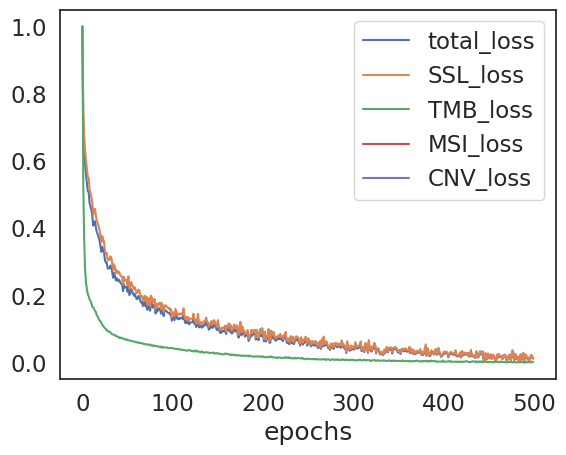

In [14]:
df = pd.DataFrame(performace, columns = ['epochs', 'total_loss', 'SSL_loss', 'TMB_loss', 'MSI_loss', 'CNV_loss']).set_index('epochs')
v = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
v.plot()

<Axes: xlabel='epochs'>

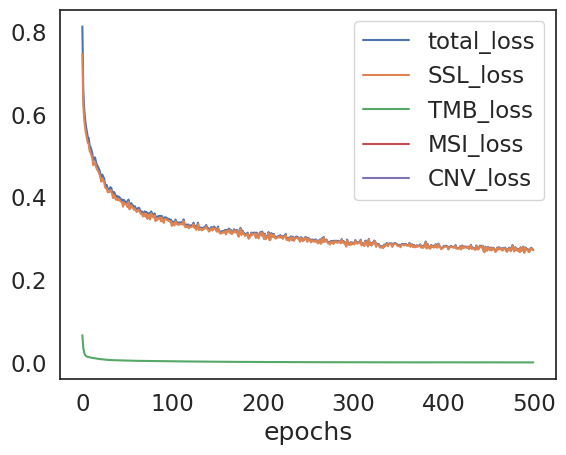

In [15]:
df.plot()

In [17]:
import torch.nn as nn
### for make prediction
model = TCGAPretrainModel(input_dim, middle_emb_dim=512, out_emb_dim=out_emb_dim)
model.load_state_dict(saver.inMemorySave['model_state_dict'])

from train import predict
dfe, dfp = predict(df_tpm, model,  device='cpu', SL_tasks = SL_tasks)

In [18]:
emb = torch.tensor(dfe.values).to('cpu')

In [19]:
model.tmb_predictor(emb)

tensor([[0.2421],
        [0.3847],
        [0.4356],
        ...,
        [0.2630],
        [0.2113],
        [0.2199]], grad_fn=<AddmmBackward0>)

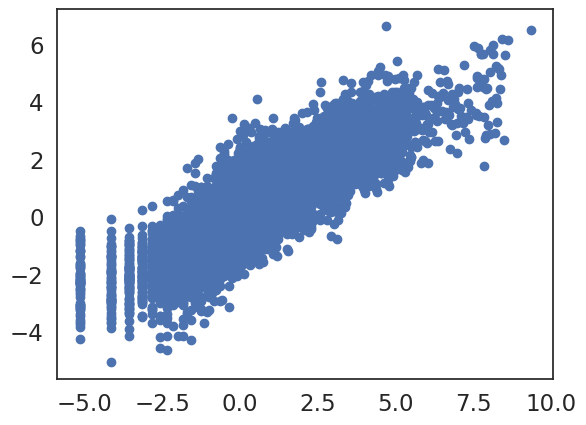

In [20]:
plt.scatter(df_tmb.tmb, train_tcga.tmb_scaler.inverse_transform(dfp[['tmb']]).reshape(-1,))

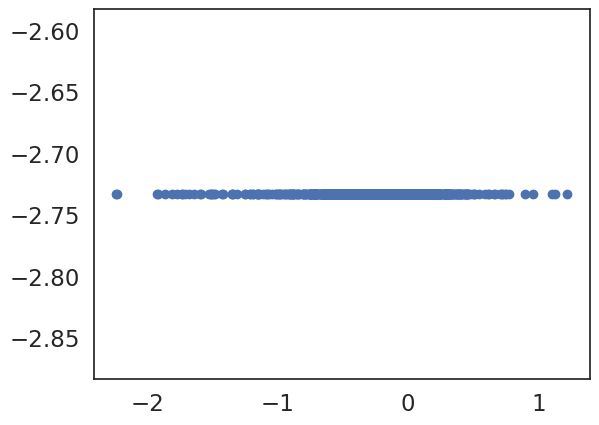

In [21]:
plt.scatter(df_cnv.cnv, train_tcga.cnv_scaler.inverse_transform(dfp[['cnv']]).reshape(-1,))

In [22]:
tcga_label.columns

Index(['cancer_type', 'age', 'gender', 'race', 'stage', 'vital_status',
       'tumor_status', 'treatment_outcome', 'os_status', 'os_time',
       'pfi_status', 'pfi_time', 'tmb', 'cnv', 'msi', 'truncate_mut',
       'nontruncate_mut', 'msi_score'],
      dtype='object')

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

UMAP(n_neighbors=32, random_state=42, spread=1, verbose=1)
Sat Oct 14 21:27:40 2023 Construct fuzzy simplicial set
Sat Oct 14 21:27:40 2023 Finding Nearest Neighbors
Sat Oct 14 21:27:40 2023 Building RP forest with 10 trees
Sat Oct 14 21:27:44 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sat Oct 14 21:28:04 2023 Finished Nearest Neighbor Search
Sat Oct 14 21:28:06 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sat Oct 14 21:28:18 2023 Finished embedding


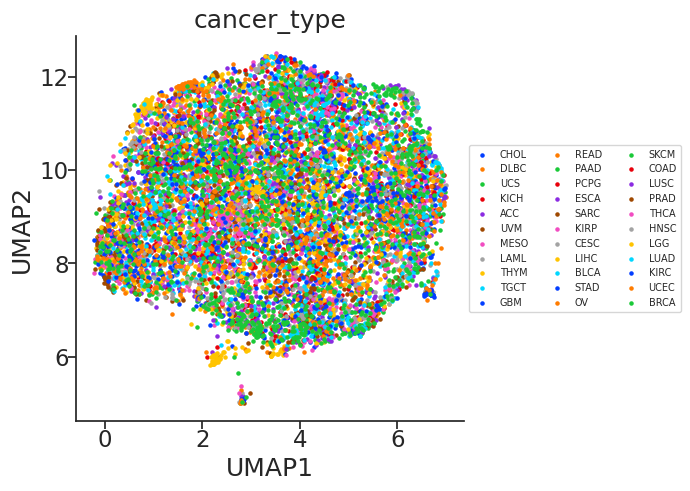

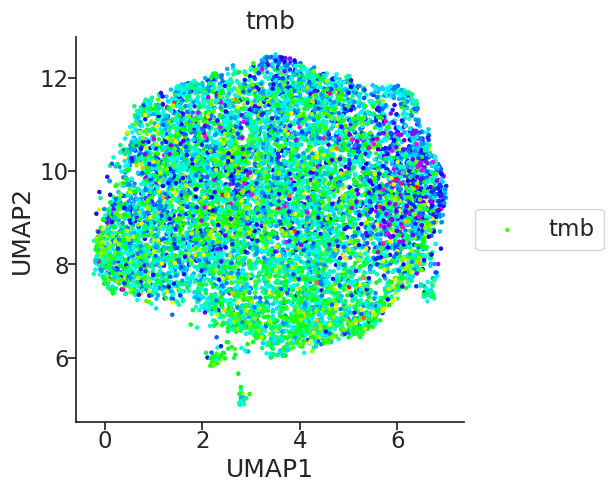

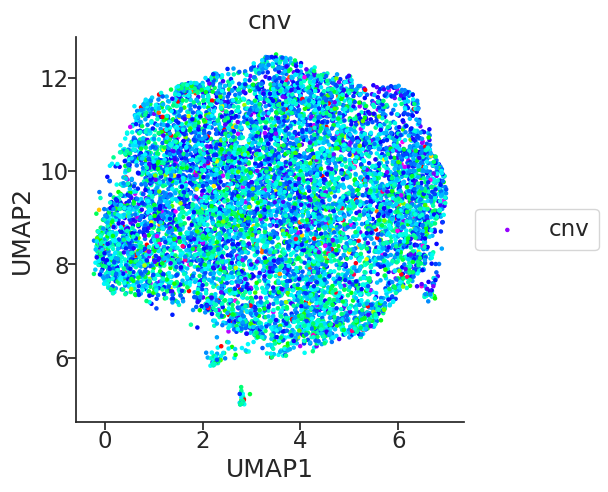

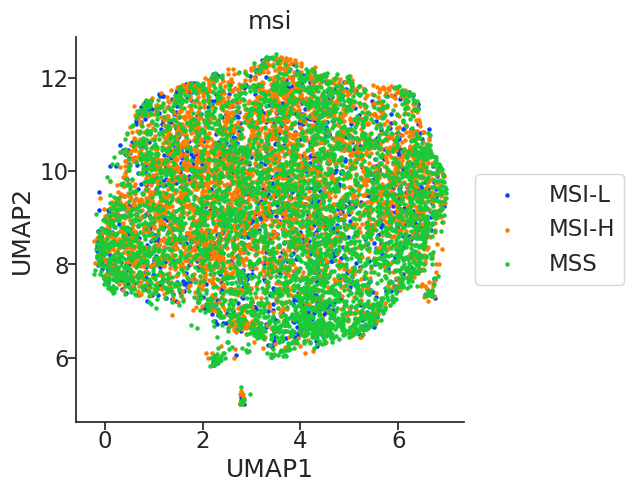

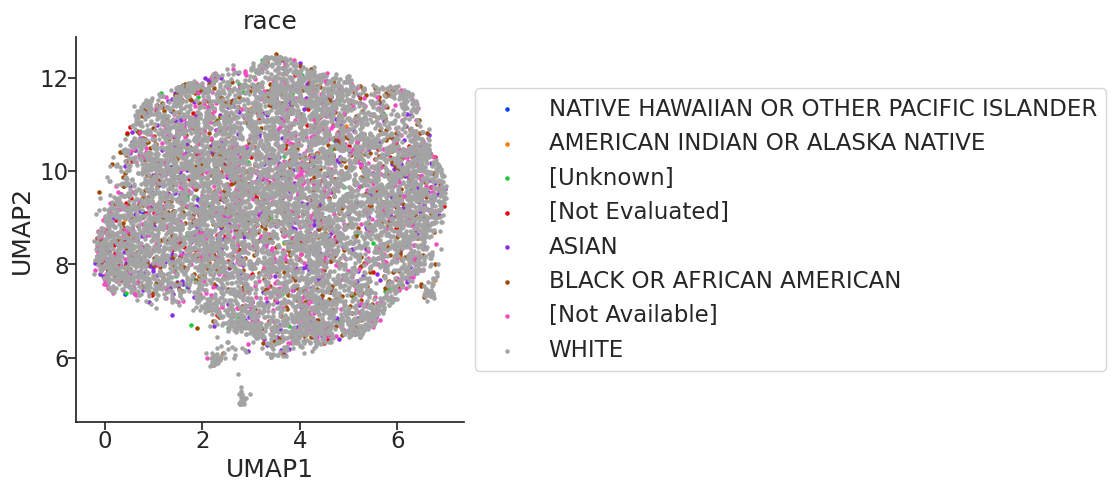

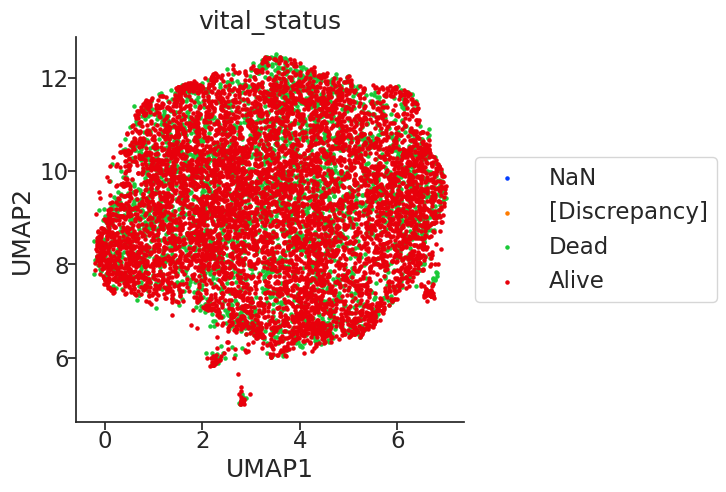

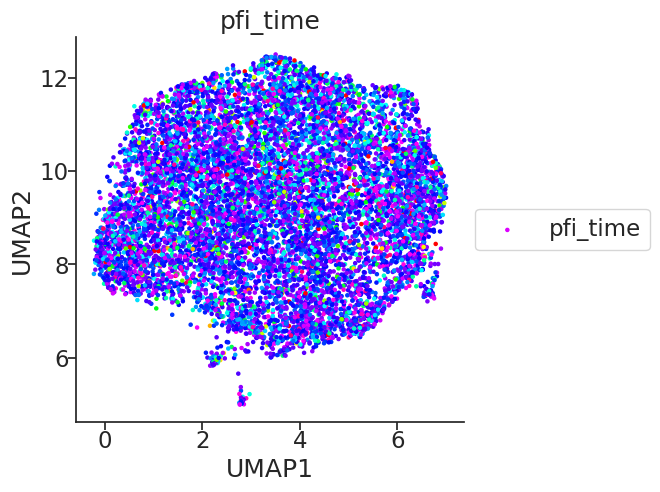

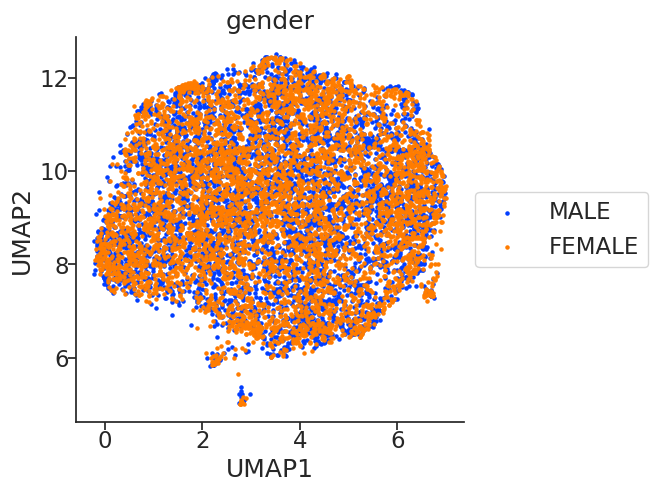

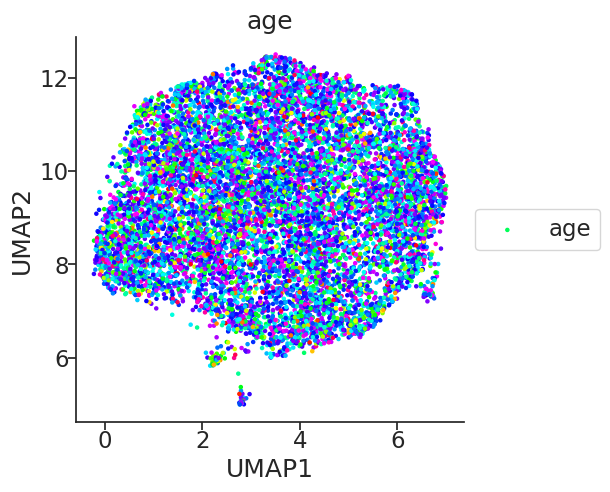

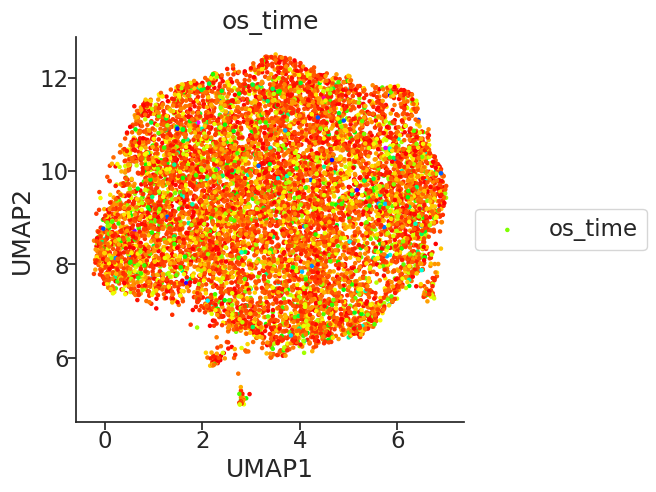

In [23]:
from plot import plot_embed_with_label
dfc = df_cancer.cancer_type.apply(lambda x:x.replace('TCGA-', ''))
msi = tcga_label[['msi']]
cnv = tcga_label.cnv.clip(-1, 0.5).to_frame(name='cnv')

l1 = tcga_label[['race', 'vital_status']].fillna('NaN')
l2 = np.log10(tcga_label[['pfi_time']]+1)
l3 = tcga_label[['gender', 'age', 'os_time']]

dfd = dfe.join(dfc).join(dfp.tmb).join(cnv).join(msi).join(l1).join(l2).join(l3)

figs = plot_embed_with_label(dfd, 
                             label_col = ['cancer_type', 'tmb', 'cnv', 'msi','race', 'vital_status',
                                          'pfi_time', 'gender', 'age', 'os_time'],  
                             label_type = ['c', 'r', 'r', 'c','c', 'c', 'r',  'c', 'r', 'r'], figsize=(5,5))

# Downstream Tasks

In [24]:
itrp_x = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
itrp_meta = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
itrp_meta['response_label'] = itrp_meta['Freeman_response']
itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']

itrp_y = itrp_meta[['response_label']]
itrp_c = itrp_meta[['cohort']]
itrp_meta.groupby('cohort')['response_label'].value_counts().unstack().T

itrp_dfe, itrp_dfp = predict(itrp_x, model,  device='cpu', SL_tasks = SL_tasks)

/tmp/ipykernel_27345/2597270193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']


In [25]:
tmb_pred = train_tcga.tmb_scaler.inverse_transform(itrp_dfp[['tmb']])
tmb_pred = pd.DataFrame(tmb_pred, index = itrp_dfp.index, columns=['tmb'])

In [26]:
dfpp = tmb_pred.join(itrp_meta[['tmb.wang', 'cohort']])

In [27]:
dfpp.groupby('cohort')[['tmb', 'tmb.wang']].apply(lambda x:x.corr().iloc[0][1])

cohort
Allen    0.152585
Gide          NaN
Hugo     0.211189
Liu      0.321593
MGH      0.067615
Riaz     0.232844
dtype: float64

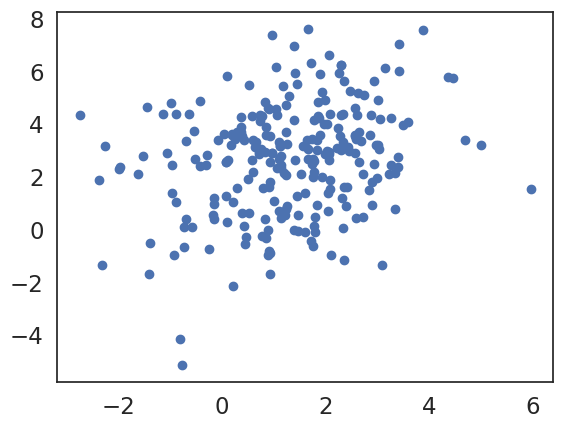

In [28]:
plt.scatter(dfpp.tmb, dfpp['tmb.wang'])

UMAP(n_neighbors=32, random_state=42, spread=1, verbose=1)
Sat Oct 14 21:28:25 2023 Construct fuzzy simplicial set
Sat Oct 14 21:28:25 2023 Finding Nearest Neighbors
Sat Oct 14 21:28:27 2023 Finished Nearest Neighbor Search
Sat Oct 14 21:28:27 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Oct 14 21:28:29 2023 Finished embedding


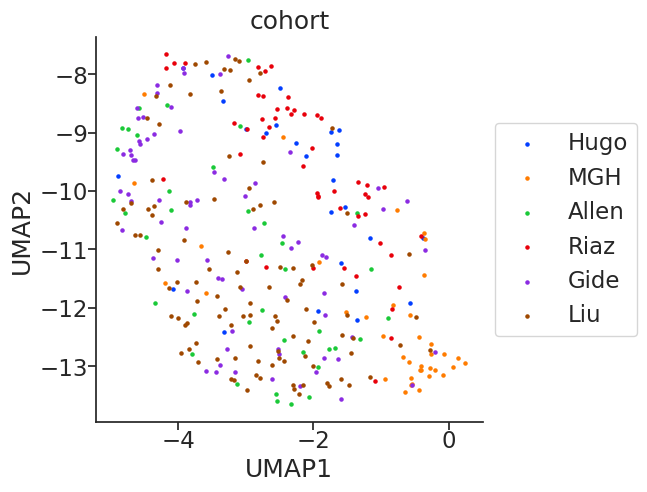

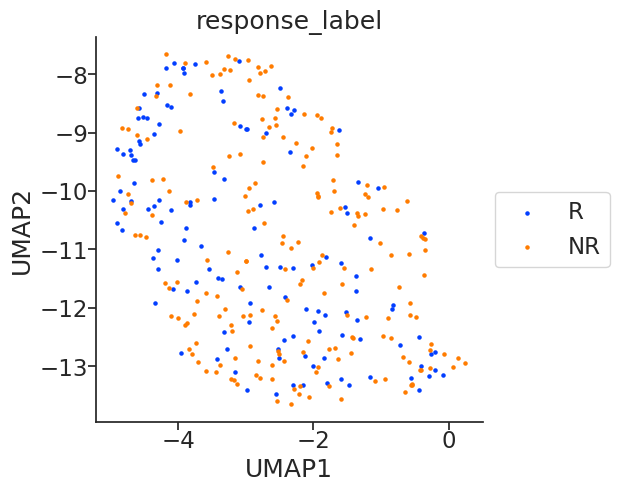

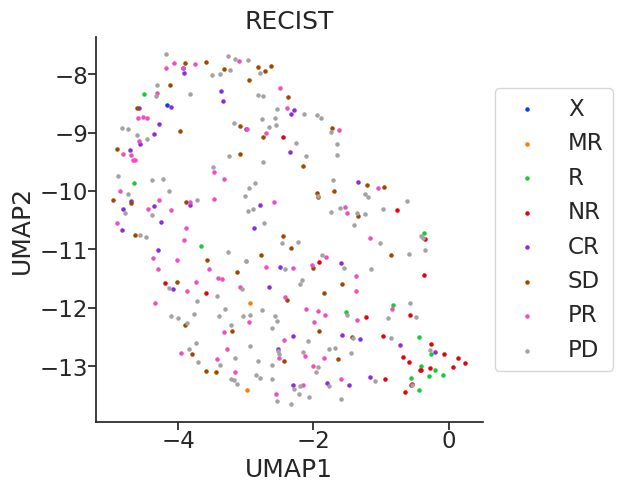

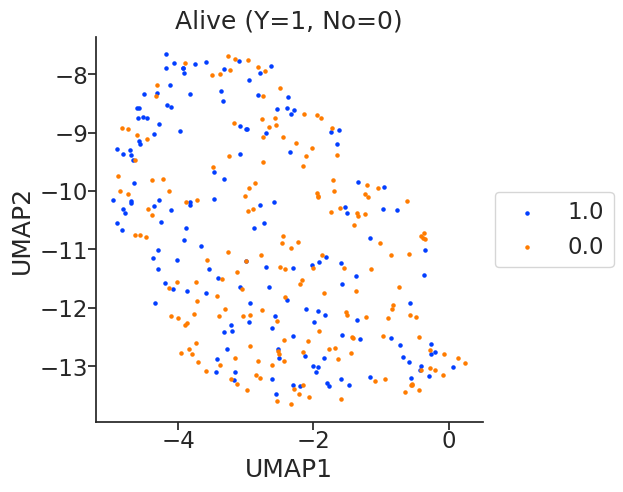

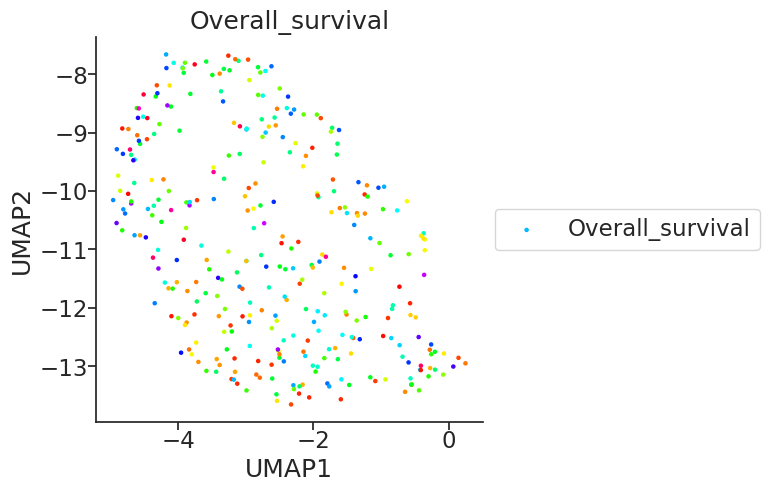

In [29]:
from plot import plot_embed_with_label

cols = ['cohort','response_label','RECIST','Alive (Y=1, No=0)', 'Overall_survival']
types = ['c', 'c', 'c', 'c', 'r']

dfd = itrp_dfe.join(itrp_meta[cols])

figs = plot_embed_with_label(dfd, 
                             label_col = cols,  
                             label_type = types, figsize=(5,5))